Homework 8 : Bert Zhao
===

**<span style="color: darkgreen">Due Friday May 29 at 11:59pm</span>**

Relevant reading: Nise Ch12.1 12.2 12.3 12.5 12.6 12.8


In [0]:
!pip install control
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *
from control import *

%matplotlib inline

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

     |████████████████████████████████| 256kB 2.7MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=d5971c4a26a9103cb9d220d94eb3926d49240c77aa965344d417b6f60a184836
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


# 0. Dominant Poles (12pts)
For system
$$
G(s)=2a\frac{s+1}{(s+a)(s^2+2s+2)},
$$
- a) What are the poles? (2pts)
- b) What is the steady state output response to a unit step? (2pts)
- c) Co-plot (i.e. all 4 plots on the same axes) the step response of the above system for $a=\{\frac{1}{2},2,10\}$ as well as the step response of 
$$ G_2(s) = \frac{2}{s^2+2s+2}$$
(8pts)


Tip: you may find the [control package's](https://python-control.readthedocs.io/en/0.8.3/generated/control.step_response.html) `step_response` function useful.  (note `step_response` takes a `TransferFunction` model which you can generate with the `tf` function.

## a)

Solving for the denomintor of the transfer function, we get that the three poles of the system are located at $-a$, $-1+i$, and $-1-i$.

## b)

Using the Final Value Theorum, we can find the steady state output of the system with a step input.

$$f(\infty) = F(s) \lim_{s \to 0} s \frac{1}{s} G(s) = \lim_{s \to 0} 2a\frac{s+1}{(s+a)(s^2+2s+2)} = \lim_{s \to 0} \frac{2a}{2a} = 1$$

We can varify this steady state solution by plotting.

## c)

The plots of all four functions are shown below. We can see that they all approach a steady state of 1. The different values of $a$ change the poles and they affect the overshoot and settling time of the system. In general, greater values of $a$ give the system a lower settling time but greater overshoot.

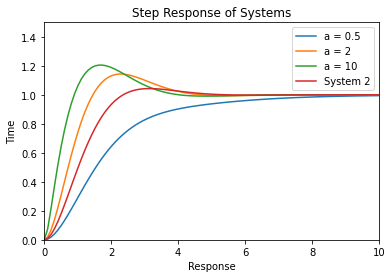

In [0]:
time = np.linspace(0, 10, 100)
for a in [0.5, 2, 10]:
  sys = tf([2*a, 2*a], [1, 2+a, 2+2*a, a*2])
  r, t = step_response(sys, time)
  plt.plot(r, t, label= 'a = ' + str(a))

sys2 = tf([2], [1, 2, 2])
r, t = step_response(sys2, time)
plt.plot(r, t, label = 'System 2')

plt.xlim(0, 10)
plt.ylim(0, 1.5)
plt.xlabel("Response")
plt.ylabel("Time")
plt.title("Step Response of Systems")
plt.legend()

# 1. Full State Feedback

For each of the following systems:  (You may use symbolic algebra tools but you may not use the control tool box functions like 'place'.)

- a) transform the system into state space using whatever form you like
- b) design a full state feedback controller to place the system poles at $-1 \pm
j$
- c) find the closed loop transfer function of the system
- d) find the steady state error from a unit step input.

System one: $\frac{\displaystyle s+1}{\displaystyle s^2+5s+1}$

System two: $\frac{\displaystyle s+2}{\displaystyle  s^2+s}$


# System 1

### a)

Transforming the system into state space using Phase Canonical form, we get:

$$\frac{s+1}{s^2+5s+1} = \frac{b_1s+b_0}{s^2+a_1s+a_0}$$

$$b_1 = 1, b_0 = 1, a_1 = 5, a_0 = 1$$

$$
A = \begin{pmatrix} 
  0 & 1 \\
  -1 & -5
\end{pmatrix}$$

$$
B = \begin{pmatrix}
0 \\
1
\end{pmatrix}
$$

$$
C = \begin{pmatrix} 1 & 1 \end{pmatrix}
$$

Which gives a state space representation of:

$$
\dot x = \begin{pmatrix} 
  0 & 1 \\
  -1 & -5
\end{pmatrix} x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u
$$ 

$$
y = \begin{pmatrix} 1 & 1 \end{pmatrix} x
$$

### b) 

To place the poles of the system at $-1 \pm i$ we need the characteristic polynomial of the denominator to equal $s^2 + 2s + 2$. We can implement this with a feedback gain which gives the following state space representation of the system: $\dot x = (A-BK) x + Br$.

First we must do coeffecient matching to find the values in matrix $K$.

$$s^2 + (5+k_1) s + (1+k_0) = s^2 + 2s + 2 $$

$$ 5+k_1 = 2; k_1 = -3 $$

$$ 1 + k_0 = 2; k_0 = 1 $$

Then we can find matrix $A' = (A-BK)$ for the new system with a feedback controller.

$$
A' = \begin{pmatrix} 
  0 & 1 \\
  -2 & -2
\end{pmatrix}
$$

This gives a  following state space representation of the system:

$$
\dot x = \begin{pmatrix} 
  0 & 1 \\
  -2 & -2
\end{pmatrix} x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u
$$ 

$$
y = \begin{pmatrix} 1 & 1 \end{pmatrix} x
$$

### c)

We can find the transfer function for this system by solving $T(s) = C(sI - A')B^{-1}$.

$$T(s) = \frac{s+1}{s^2 + 2s + 2}$$


### d)

We know that in general, steady state error is given by:

$$E(s) = R(s) - Y(s)$$

And in this case, $Y(s) = R(s)T(s)$.

Therefore, the steady state error can be found using the Final Value Theorum.

$$\lim_{s \to 0} sE(s) = \lim_{s \to 0} s (\frac{1}{s} - \frac{1}{s} \cdot \frac{s+1}{s^2 + 2s + 2}) = \lim_{s \to 0} (1 - \frac{s+1}{s^2 + 2s + 2}) = \frac{1}{2}$$

The steady state error of system 1 with a step input is $\frac{1}{2}$.


# System 2

### a)

Transforming the system into state space using Phase Canonical form, we get:

$$\frac{s+2}{s^2+s} = \frac{b_1s+b_0}{s^2+a_1s+a_0}$$

$$b_1 = 1, b_0 = 2, a_1 = 1, a_0 = 0$$

$$
A = \begin{pmatrix} 
  0 & 1 \\
  0 & -1
\end{pmatrix}$$

$$
B = \begin{pmatrix}
0 \\
1
\end{pmatrix}
$$

$$
C = \begin{pmatrix} 2 & 1 \end{pmatrix}
$$

Which gives a state space representation of:

$$
\dot x = \begin{pmatrix} 
  0 & 1 \\
  0 & -1
\end{pmatrix} x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u
$$ 

$$
y = \begin{pmatrix} 2 & 1 \end{pmatrix} x
$$

### b) 

To place the poles of the system at $-1 \pm i$ we need the characteristic polynomial of the denominator to equal $s^2 + 2s + 2$. We can implement this with a feedback gain which gives the following state space representation of the system: $\dot x = (A-BK) x + Br$.

First we must do coeffecient matching to find the values in matrix $K$.

$$s^2 + (1+k_1) s + (k_0) = s^2 + 2s + 2 $$

$$ 1+k_1 = 2; k_1 = 1 $$

$$ k_0 = 2$$

Then we can find matrix $A' = (A-BK)$ for the new system with a feedback controller.

$$
A' = \begin{pmatrix} 
  0 & 1 \\
  -2 & -2
\end{pmatrix}
$$

This gives a  following state space representation of the system:

$$
\dot x = \begin{pmatrix} 
  0 & 1 \\
  -2 & -2
\end{pmatrix} x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u
$$ 

$$
y = \begin{pmatrix} 2 & 1 \end{pmatrix} x
$$

### c)

We can find the transfer function for this system by solving $T(s) = C(sI - A')B^{-1}$.

$$T(s) = \frac{s+2}{s^2 + 2s + 2}$$

### d)

We know that in general, steady state error is given by:

$$E(s) = R(s) - Y(s)$$

And in this case, $Y(s) = R(s)T(s)$.

Therefore, the steady state error can be found using the Final Value Theorum.

$$\lim_{s \to 0} sE(s) = \lim_{s \to 0} s (\frac{1}{s} - \frac{1}{s} \cdot \frac{s+2}{s^2 + 2s + 2}) = \lim_{s \to 0} (1 - \frac{s+2}{s^2 + 2s + 2}) = 0$$

The steady state error of system 2 with a step input is $0$.


In [0]:
s = symbols('s')

A1 = Matrix([[0, 1], [-2, -2]])
B1 = Matrix([[0], [1]])
C1 = Matrix([[1, 1]])

T1 = C1*(s*eye(2)-A1).pinv() * B1
display(simplify(T1))

⎡   s + 1    ⎤
⎢────────────⎥
⎢ 2          ⎥
⎣s  + 2⋅s + 2⎦

In [0]:
A2 = Matrix([[0, 1], [-2, -2]])
B2 = Matrix([[0], [1]])
C2 = Matrix([[2, 1]])

T2 = C2*(s*eye(2)-A2).pinv() * B2
display(simplify(T2))

⎡   s + 2    ⎤
⎢────────────⎥
⎢ 2          ⎥
⎣s  + 2⋅s + 2⎦

# 2. Integrator

System one above has a steady state error. Define a control system with full state feedback and an integrator that puts the closed loop poles at -10 and $-1 \pm j$. Simulate the system response to a step input.

To find a closed loop integrator for the system, we need to add an integrator component that fits the following:

$$\dot x = Ax + Bu$$
$$\dot x_i = r-Cx$$
$$y=Cx$$

We can then define a new state space as follows:

$$ \dot{\hat{x}} = \begin{pmatrix} 
  A & 0 \\
  -C & 0
\end{pmatrix} + \begin{pmatrix}
B \\
0
\end{pmatrix} u + \begin{pmatrix}
0 \\
1
\end{pmatrix} r$$

We can define new matrixes as follows:

$$\dot{\hat{A}} = \begin{pmatrix} 
  A & 0 \\
  -C & 0
\end{pmatrix} = \begin{pmatrix} 
  0 & 1 & 0 \\
  -1 & -5 & 0 \\
  1 & 1 & 0
\end{pmatrix}$$

$$\dot{\hat{B}} = \begin{pmatrix}
B \\
0
\end{pmatrix} = \begin{pmatrix}
0 \\
1 \\
0
\end{pmatrix}$$

We also have the gain feedback gain matrix:

$$K = \begin{pmatrix}
k_0 & k_1 & k_i
\end{pmatrix}$$

Then we can find the eigenvalues of $\hat{A} - \hat{B}K = A'$:

$$\det(sI - A') = s^3 + (k_1 + 5)s^2 + (k_0 + k_i + 1)s + k_i$$

And we can do coeffecient matching with the denominator of the system with the poles we want to place to find the gains.

$$ s^3 + (k_1 + 5)s^2 + (k_0 + k_i + 1)s + k_i = s^3 + 12s^2 + 22s + 20 $$

$$k_0 = 1, k_1 = 7, k_i = 20$$

We can then define the state space matrices of the full system with as:

$$ A' = \begin{pmatrix} 
  0 & 1 & 0 \\
  -2 & -12 & -20 \\
  1 & 1 & 0
\end{pmatrix}$$

$$B' = \begin{pmatrix}
0 \\
0 \\
1
\end{pmatrix}$$

$$ C' = \begin{pmatrix}
1 & 1 & 0
\end{pmatrix}$$

And we can solve for the transfer function.

$$T(s) = C'(sI - A')^{-1}B' = \begin{matrix}\frac{20 \left(s + 1\right)}{s^{3} + 12 s^{2} + 22 s + 20}\end{matrix}$$

A plot of the system with a step input is shown below.

In [0]:
# 

var("s k0 k1 ki")
A = Matrix([
    [0,1,0],
    [-1-k0,-5-k1,ki],
    [-1, -1, 0]
])
poly = (s*eye(3)-A).det().collect(s)
poly

      2                               
ki + s ⋅(k₁ + s + 5) + s⋅(k₀ + ki + 1)

In [0]:
solve(
    Matrix([Poly(poly,s).coeffs()]) 
    - Matrix([[1,12,22,20]])
,[k0,k1,ki])

{k₀: 1, k₁: 7, ki: 20}

In [0]:
s = symbols('s')

A3 = Matrix([[0, 1, 0], [-2, -12, 20], [-1, -1, 0]])
B3 = Matrix([[0], [0], [1]])
C3 = Matrix([[1, 1, 0]])



T3 = C3*(s*eye(3)-A3).pinv() * B3
display(simplify(T3))

⎡      20⋅(s + 1)      ⎤
⎢──────────────────────⎥
⎢ 3       2            ⎥
⎣s  + 12⋅s  + 22⋅s + 20⎦

Text(0.5, 1.0, 'Response of Step Input')

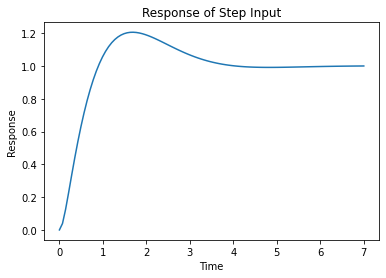

In [0]:
sys3 = tf([20, 20], [1, 12, 22, 20])
r, t = step_response(sys3)
plt.plot(r, t)
plt.xlabel("Time")
plt.ylabel("Response")
plt.title("Response of Step Input")

# 3. Controllability and Observability

Consider the following state space system.

\begin{align}
\dot x & = \begin{pmatrix}
0 & -1 \\
-1 & 1
\end{pmatrix} x + \begin{pmatrix}
0 \\
a
\end{pmatrix} u \\
y & = \begin{pmatrix}
b+1 & b
\end{pmatrix} x
\end{align}

- a) For what values of $a$ and $b$ is the system controllable?
- b) For what values of $a$ and $b$ is the system observable?

Determine the above by using the controllability and observability matrices.

## a)

We can find the controllability matrix as follows:

$$
M = \left( B \; AB \right) = \begin{pmatrix} 
  0 & -a \\
  a & a
\end{pmatrix}
$$

$M$ has full rank when $a \ne 0$. $b$ can be any value since the controllability does not depend on $b$.

## b)

We can find the observability matrix as follows:

$$\mathcal{O} = \begin{pmatrix}
C \\
CA \\
\end{pmatrix} = \begin{pmatrix} 
  b+1 & b \\
  -b & -1
\end{pmatrix}
$$

We can then row reduce $\mathcal{O}$ to check for linear independence.

$$\begin{pmatrix} 
  b+1 & b \\
  -b & -1
\end{pmatrix} \xrightarrow{R_1+R_2 \rightarrow R_1}\begin{pmatrix} 
  1 & b-1 \\
  -b & -1
\end{pmatrix} \xrightarrow{R_1b + R_2 \rightarrow R_2}
\begin{pmatrix} 
  1 & b-1 \\
  0 & b^2-b-1
\end{pmatrix}$$

The rows are linearly independent if $b^2-b-1 \ne 0$. Therefore if:

$$b \ne \frac{1 \pm \sqrt5}{2}$$

The system will be observable. $a$ can be any value since observability does not depend on $a$.

In [0]:
def MatrixFromColumns(clist):
    return Matrix(clist).reshape(
        clist[0].shape[0], 
        len(clist)).transpose()

In [0]:
a = symbols("a")

A4 = Matrix([[0, -1], [-1, 1]])
B4 = Matrix([[0], [a]])

M = MatrixFromColumns([B4, A4*B4])
display(M)
M.rank()

⎡0  -a⎤
⎢     ⎥
⎣a  a ⎦

2

In [0]:
b = symbols("b")

A4 = Matrix([[0, -1], [-1, 1]])
C4 = Matrix([[b+1, b]])

O = Matrix([C4, C4*A4])
display(O)
O.rank()

⎡b + 1  b ⎤
⎢         ⎥
⎣ -b    -1⎦

2

# 4. Full State Feedback and Observer Design

Consider the plant

$$
G(s) = \frac{s+1}{(s+a)(s+8)(s+10)}
$$

where $a = 1$. 

- a) Find a convenient state space representation of model $G(s)$.
- b) Using `place` design a controller for the system that puts the poles at $-0.5$ and $-2 \pm -2j$.
- c) Using `place` design an observer with poles at -10, -11 and -12. 
- d) Simulate the closed loop system with the observer and the controller with a step input. Make sure to start the observer and plant with different states. Plot the states with the state estimates overlaid. 
- e) Find a state space representation of the closed loop system and show that its $A$ matrix has the six poles you placed.

## a)

We can expand the denominator of $G(s)$ and then use Phase Canonical Form to transform the system into state space. This gets us the following:

$$G(s) = \frac{s+1}{s^{3} + 18.5 s^{2} + 89.0 s + 40.0}$$

$$ A = \begin{pmatrix} 
  0 & 1 & 0 \\
  0 & 0 & 1 \\
  -40 & -89 & -18.5
\end{pmatrix}$$

$$B = \begin{pmatrix}
0 \\
0 \\
1
\end{pmatrix}$$

$$ C = \begin{pmatrix}
1 & 1 & 0
\end{pmatrix}$$

## b)

Using `place`, we get the following for matrix $K$:

$$K = \begin{pmatrix}-36.0 & -79.0 & -14.0\end{pmatrix}$$

## c)

Using `place`, we get the following for matrix $L$:

$$L = \begin{pmatrix}32.0\\-18.0\\23.0\end{pmatrix}$$

## d)

A plot of the system with a step input is shown below. The initial condidtitons are:

$$\begin{pmatrix}
x \\
\hat{x}
\end{pmatrix} = \begin{pmatrix}
5 \\
2 \\
1 \\
0 \\
0 \\
0
\end{pmatrix}$$

## e)

In general, the state space of the system with controller and oberserver looks like:

$$\begin{align}
\begin{pmatrix}
\dot{x} \\
\dot{\hat{x}}
\end{pmatrix} & = 
\begin{pmatrix}
A & -BK \\
LC & A - BK - LC
\end{pmatrix} \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix} + \begin{pmatrix}
B \\
B
\end{pmatrix} r \\
y & = ( \; C \;  0 \; ) \; \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix}
\end{align}$$

Then for our system, we get:

$$\begin{align}
\begin{pmatrix}
\dot{x} \\
\dot{\hat{x}}
\end{pmatrix} & = 
\left[\begin{matrix}0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 1.0 & 0 & 0 & 0\\-40.0 & -89.0 & -19.0 & 36.0 & 79.0 & 14.0\\32.0 & 32.0 & 0 & -32.0 & -31.0 & 0\\-18.0 & -18.0 & 0 & 18.0 & 18.0 & 1.0\\23.0 & 23.0 & 0 & -27.0 & -33.0 & -4.5\end{matrix}\right] \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix} + \begin{pmatrix}
0 \\
0 \\
1 \\
0 \\
0 \\
1
\end{pmatrix} r \\
y & = ( \; 1 \; 1 \; 1 \;  0 \; 0 \; 0 \;) \; \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix}
\end{align}$$

Using Python to solve for the eigenvalues of $A$, we get back the original poles that we placed which is shown below.

In [0]:
# expand denominator
var("s")
latex(((s+0.5)*(s+8)*(s+10)).expand())

's^{3} + 18.5 s^{2} + 89.0 s + 40.0'

In [0]:
# use place to solve for K and L
A = Matrix([
    [0,1,0],
    [0,0,1],
    [-40, -89, -18.5]
    ])

B = Matrix([
    [0],
    [0],
    [1]
])

C = Matrix([[1,1,0]])

An = np.array(A).astype(np.float64)
Bn = np.array(B).astype(np.float64)
Cn = np.array(C).astype(np.float64)

K = Matrix(place(An,Bn,[-0.5, -2+2*1j, -2-2*1j]))

L = Matrix(np.transpose(
        place(np.transpose(An),np.transpose(Cn), [-10, -11, -12]))
    )
N(K,2),N(L,2)

⎛                       ⎡32.0 ⎤⎞
⎜                       ⎢     ⎥⎟
⎜[-36.0  -79.0  -14.0], ⎢-18.0⎥⎟
⎜                       ⎢     ⎥⎟
⎝                       ⎣23.0 ⎦⎠

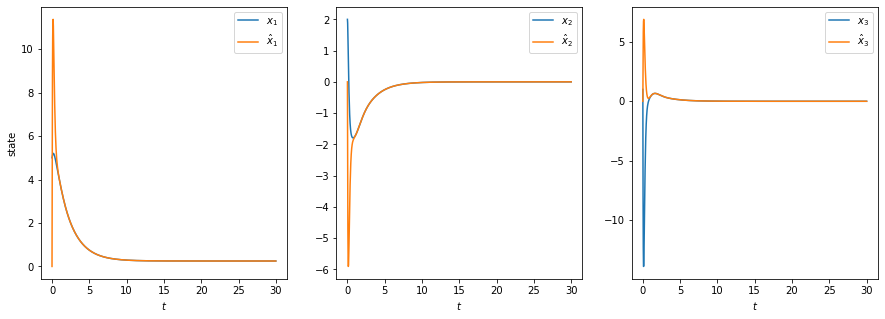

In [0]:
# simulate with step input and different inital states
def input(t):
    if t > 0:
        return 1
    else:
        return 0
    
def f(X,t):
    x = Matrix(X[:3]) #can either make x a Matrix or use np.dot instead of *
    xhat = Matrix(X[3:6])
    u = -(K*xhat)[0] + input(t)
    fb = L * ( C*x - C*xhat )
    return flatten(
        (A*x + B*u).tolist() + 
        (A*xhat + B*u + fb).tolist())

t=np.linspace(0,30,1000)
X = spi.odeint(f,[5,2,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()
    
ax[0].set_ylabel("state");

In [0]:
# find new matrix A
top = Matrix([A.transpose(), -(B*K).transpose()]).transpose()
bot = Matrix([(L*C).transpose(), (A-B*K-L*C).transpose()]).transpose()
Atilde = Matrix([top,bot])
N(Atilde,2)

⎡  0     1.0     0      0      0     0  ⎤
⎢                                       ⎥
⎢  0      0     1.0     0      0     0  ⎥
⎢                                       ⎥
⎢-40.0  -89.0  -19.0  36.0   79.0   14.0⎥
⎢                                       ⎥
⎢32.0   32.0     0    -32.0  -31.0   0  ⎥
⎢                                       ⎥
⎢-18.0  -18.0    0    18.0   18.0   1.0 ⎥
⎢                                       ⎥
⎣23.0   23.0     0    -27.0  -33.0  -4.5⎦

In [0]:
# check e-values
e,v = np.linalg.eig(np.array(Atilde.tolist()).astype(np.float64));
e

array([-12. +0.j, -11. +0.j, -10. +0.j,  -0.5+0.j,  -2. +2.j,  -2. -2.j])